# Disaster Damage Prediction from Satellite Imagery

**Author: Md Saimoom Ferdous**

This project outlines satellite image pre-processing steps with Tensorflow 2.3 version. Main objective is to predict from a satellite image whether it contains flooding damaged area.  

### 1. Data Collection
Satellite image data was collected from the Kaggle website (https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage). It contains images of hurricane Harvey devasted area of Texas.

#### Import Necessary Libraries

In [21]:
# import necessary libraries to pre-process and plot the data

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### Load Image Data

In [22]:
# define image parameters

batch_size = 32   # no. of image samples to update CNN weights
img_height = 128  # image chip size
img_width = 128

In [23]:
# Train and valid data directory

train_data_dir = './data2/train_valid/'

In [24]:
# Out of 12K samples, 1000 will be taken to limit on train computation time

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.9167,
  subset="training",
  seed=2020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12000 files belonging to 2 classes.
Using 1000 files for training.


In [25]:
# Extrcat 200 validation samples

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.0167,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12000 files belonging to 2 classes.
Using 200 files for validation.


In [26]:
# Plot the class names to mke sure data was extracted rightly

class_names = train_ds.class_names
print(class_names)

['damage', 'no_damage']


In [8]:
# Test data directory

test_data_dir = './data2/test/'

In [27]:
# Extract 200 test samples, to limit train computation time

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  validation_split=0.0223,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 2 classes.
Using 200 files for validation.


In [29]:
# Make sure the image size is okay

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


#### Plot Sample Images

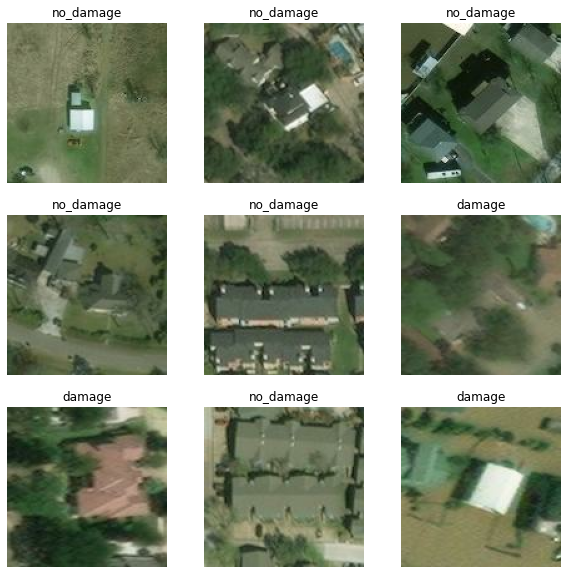

In [28]:
# plot first 9 images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Configure the Dataset for Performance

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# .cache() keeps the image data in memory during first epoch

train_ds = train_ds.cache().shuffle(len(train_ds)).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize
Data will be standardized at the first layer of model architecture

### 2. Modelling
#### Model Architecture

In [36]:
# We will limit training to one layer CNN architecture for quick computation

num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # scale pixel value to 0-1
  layers.Conv2D(16, 3, padding='same', activation='relu'), # 16 convolutional filters
  layers.MaxPooling2D(),       # by default MaxPooling2D stride is 2
    
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
    
  layers.Dropout(0.2), # (%) of the weak nodes left out of training to bolester other nodes weights
    
  layers.Flatten(),  # flatten the 'matrix' output to a single 'vector' layer 
  layers.Dense(32, activation='relu'), # first hidden layer of the NN after the CNN, whose size can be tweaked
  layers.Dense(num_classes, activation = 'softmax') # to generate prediction probabilities ofr each classes
])

#### Compile the Model

In [37]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Summary

In [38]:
# Model architecture

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2097184   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

#### Model Training

In [ ]:

# Number of training epochs
max_epochs = 10
    
# Early stopping: Allow for 2 instances of training after minimum loss point reached for for train/validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
# fit the model
train_mod = model.fit(train_ds, # train inputs
                      epochs=max_epochs, # number of iteration the training will run, unless early stopping kicks in
                      callbacks=[early_stopping], # early stopping
                      validation_data= val_ds, # validation data
                      verbose = 2 # print minimum information during training
                     )  
    

Epoch 1/10


- With the current hardware setting, model training did not progress further even after 8 hours of run
- Possible suggestion would be trying in the cloud infrastucture 

### 3. Overfitting

Although the training run was not successful and the state of the overfitting (gap between validation and test accuray) was not determined. More or overfitting is seen in any machine learning/deep learning problem. To address this issue, many techniques can be applied. Off the chart, applying 'dropout' and 'data augmentation' are noteworthy.

**Dropout** : Involves blocking out small training weights nodes for training so that the other nodes can take on more responsibilities. As an example, how to add a dropout layer is shown in the above example.

**Data Augmentation** : Involves increasing the training data by generating synthetic data from existing training dataset. Common operations involve: rotating, zooming, fliping around the original image data.

#### Data Augmentation

An example of image data flip, rotation and zooming has been shown below.

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

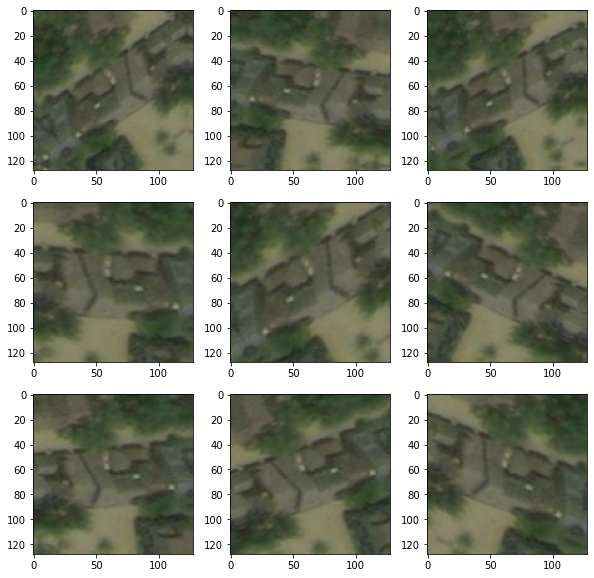

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("on")

- Every versions of the above images are different but translated from original version by flipping, rotating, zooming